
# Minecraft Metrics
I wanted to provide an example of my literacy with tensorflow for my grad applications, so I designed this simple
neural network. It looks at screenshots from Minecraft, one of my favorite video games, and provides feedback on
what the NN sees.
The images for this exploration can be found at 
https://www.kaggle.com/datasets/sqdartemy/minecraft-screenshots-dataset-with-features
I have provided a correctly organized CSV (minecraft_features_and_decisions.csv) that you should use
to make my model train and load correctly

It looks at each image and predicts a yes (1) or no (0) to the following four quesitons
- Is the player on land?
- Is the player holding an item?
- Is the player in a location where mobs (monsters) could spawn?
- Is the player at full health?

These questions are simple, but very important for anyone playing Minecraft as conditions, reactions,
and playthrough change depending on the answers. And in the future, if a computer wanted to play minecraft itself,
these would absolutely be metrics it needed to assess.

Note: this is not a simple classification network, but a **multi-label classification** network, as it studies and predicts
multiple classifications on each image

Github: https://github.com/jaccl17/imageland

### Import libraries and packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras
import random
import os
import logging
from minecraft_utils import *
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

2024-12-16 09:24:31.257800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 09:24:31.263626: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 09:24:31.320985: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 09:24:31.368011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734369871.406508    4517 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734369871.42


### Here we're just going to check for GPUs and configure them. These help speed up training and prediction.

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

print("\nTensorFlow Build Information:")
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("Is GPU available:", tf.test.is_built_with_gpu_support())


TensorFlow Build Information:
Is built with CUDA: True
Is GPU available: True


W0000 00:00:1734369873.470983    4517 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Next I'm just gonna define some global variables, these will likely not be adjusted, but can be if necessary

In [4]:
img_size = 224
autotune = tf.data.experimental.AUTOTUNE
batch_size = 500
decision_tree = np.array([['On land', 'In Water'],
                             ['Holding an Item', 'Empty-handed'], 
                             ['Mob Spawn Risk!','Safe from Mob Spawns'],
                             ['Full Health', 'Low Health']])


### Then I want to set up data organisation. This is a crucial yet often overlooked step. In order to have a function NN it's important to have well-organized data. Though this works differently than PyTorch, Tensorflow has some helpful data organizing tools

In [5]:
minecraft_data = pd.read_csv("/home/unitx/wabbit_playground/nn/minecraft_features_and_decisions.csv")
minecraft_data.head(3)
label_names = list(minecraft_data.columns[1:])

image_names = minecraft_data.iloc[:,0] # keep image names as reference
X = image_names
y = minecraft_data.iloc[:,1:] # all other columns are the labels

# Allocate 60% of data to training
X_train, X_, y_train, y_ = train_test_split(
    X, y, test_size=0.4, random_state=42
)
# Split remaining 40% into validation and test sets (20% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, test_size=0.5, random_state=42
)

In [6]:
n_labels = len(y_train.values[1])

# I tend to perform a lot of 'sanity checks' so I'll put some here to make sure everything is well-sorted
print(f'No. of training samples: {X_train.size}')
print(f'No. of validation samples: {X_val.size}')
print(f'No. of test samples: {X_test.size}')
print(f'All input data allocated correctly: {X.size == X_test.size + X_val.size + X_train.size}')

No. of training samples: 3344
No. of validation samples: 1115
No. of test samples: 1115
All input data allocated correctly: True


In [7]:
# for image_name, labels in zip(X_train, y_train.values):
#     print(f"Image: {image_name}, Labels: {labels}")

## Here are four functions for my minecraft NN
 - image_parser: This is going to read in all of the images, transform them into TF tensors, resize them for
       optimized training, and normalize the pixel values, and augment data a bit so out NN has more variety
       to learn from.

 - make_dataset: This guy is gonna do the tedious part of keeping track of our tensors and their associated labels.
       It will also cache our training dataset so that we don't have to reprocess each batch with every epoch.
       This function also batches our data.

 - plot_metrics: This won't be called until after we train, but this is one of the most important aspects.
       Here we plot the loss and accuracy of our training and validation sets. This is the best way we can assess
       model performance and decide whether we need to make adjusts (ie: learning rate, dropout, scheduler, etc).

 - decider: This is a simple function to make visualizing the results of our model a bit easier. It will output the actual and 
       predicted answers to the questions we're asking.

In [8]:
def image_parser(image_name, label):
    try:
        image_read = tf.io.read_file(image_name)
        image_decode = tf.image.decode_png(image_read, channels=3)
        image_resize = tf.image.resize(image_decode, [img_size, img_size])
        image_normalize = image_resize / 255.0
        # image_augmented = tf.image.random_flip_left_right(image_normalize)
        # image_augmented = tf.image.random_brightness(image_augmented, 0.2)
        return image_normalize, label
    except Exception as e:
        print(f"Error parsing image {image_name}: {e}")
        # Return a placeholder or handle the error appropriately
        return tf.zeros([img_size, img_size, 3]), label

def make_dataset(image_names, labels, is_training=True):
    image_names = np.array([os.path.join('/home/unitx/wabbit_playground/nn/minecraft/', str(f)) for f in image_names])
    labels = np.array(labels)

    minecraft_dataset = tf.data.Dataset.from_tensor_slices((image_names, labels))
    minecraft_dataset = minecraft_dataset.map(image_parser, num_parallel_calls=autotune)
    if is_training == True:
        minecraft_dataset = minecraft_dataset.take(batch_size).cache() # maintain dataset in memory
        minecraft_dataset = minecraft_dataset.shuffle(buffer_size = 1000)

    minecraft_dataset = minecraft_dataset.batch(batch_size)
    minecraft_dataset = minecraft_dataset.prefetch(buffer_size=autotune)

    return minecraft_dataset

def plot_metrics(history):
    metrics = history.history.keys()  # metrics from history
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics, 1):
        plt.subplot((len(metrics) + 1) // 2, 2, i)
        plt.plot(epochs, history.history[metric], label=f"Training {metric}")
        if f"val_{metric}" in history.history:
            plt.plot(epochs, history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.xticks(epochs)
        plt.legend()
        plt.xlim(1,len(epochs))
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def decider(array):
    decisions = []
    for i in range(len(array)):
        if array[i] > 0.8:
            decisions.append(decision_tree[i,0])
        else:
            decisions.append(decision_tree[i,1])
    return decisions

### Now we're gonna make the datasets. I always like to have a train, validation, and test set. Though all three are common practice, sometimes the validation set isn't used.

In [9]:
train_dataset = make_dataset(X_train, y_train.values.tolist())
val_dataset = make_dataset(X_val, y_val.values.tolist(), is_training=False)
test_dataset = make_dataset(X_test, y_test.values.tolist(), is_training=False)
# %%
# Just another check to make sure that we have batched our data and the image sizes are correct
# features (batch_size, img_size, img_size, channels)
# labels (batch_size, # labels)
try:
    for features, labels in train_dataset.take(1):
        print("Shape of features:", features.numpy().shape)
        print("Shape of labels:", labels.numpy().shape)
except Exception as e:
    print("Error iterating dataset:", e)

Shape of features: (500, 224, 224, 3)
Shape of labels: (500, 4)


2024-12-16 09:24:34.623420: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### It's time now to build the model! 
#### We're gonna use a pretrained model from ImageNet bc it has so much feature data already trained into it and it's free to use one of the faster models is MobileNet V2, we'll use that. 
#### We're also gonna build a scheduler which will decrease the training rate at the model learns. This helps avoid overfitting, as the model is less likely to fall into local minima associated with optimized parameters.
#### Our model will consist of a pretrained layer, a Relu activation layer, a dropout layer to make the model work harder to find details and a linear output layer. We don't use a sigmoid output layer, because we are using a Binary Cross Entropy layer that will perform the sigmoid actitvation for us. We will save loss and accuracy metrics to a 'history' valuable to make plotting easier.

In [10]:
pretrained_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4'
pretrained_layer = hub.KerasLayer(pretrained_url, input_shape=(img_size,img_size,3))
pretrained_layer.trainable = False # freezes the pretrained layer

In [11]:
# Scheduler
lr_schedule = tf_keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=20,
    decay_rate=0.8
)

In [12]:
# Model
model = tf_keras.Sequential([
    pretrained_layer,
    tf_keras.layers.Dense(1024, activation='relu', name='L1'),
    tf_keras.layers.Dropout(0.6),
    tf_keras.layers.Dense(n_labels, activation ='linear', name ='output')
])
# model.summary() # use this to check all layers are correct

In [13]:
# Train and fit
model.compile(
    loss=tf_keras.losses.BinaryCrossentropy(from_logits=True),
    # optimizer=tf_keras.optimizers.Adam(learning_rate=0.0008),
    optimizer = tf_keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf_keras.metrics.AUC(name='auc'), tf_keras.metrics.BinaryAccuracy()]
)

In [14]:
history = model.fit(train_dataset,
                            epochs=30,
                            validation_data=val_dataset)

Epoch 1/30
1/1 [==============================] - 9s 9s/step - loss: 0.7616 - auc: 0.5759 - binary_accuracy: 0.5630 - val_loss: 0.7953 - val_auc: 0.6228 - val_binary_accuracy: 0.6601
Epoch 2/30
1/1 [==============================] - 6s 6s/step - loss: 0.8256 - auc: 0.6342 - binary_accuracy: 0.6650 - val_loss: 0.5549 - val_auc: 0.7457 - val_binary_accuracy: 0.7101
Epoch 3/30
1/1 [==============================] - 6s 6s/step - loss: 0.6027 - auc: 0.7213 - binary_accuracy: 0.7030 - val_loss: 0.4853 - val_auc: 0.8100 - val_binary_accuracy: 0.7854
Epoch 4/30
1/1 [==============================] - 6s 6s/step - loss: 0.5216 - auc: 0.7925 - binary_accuracy: 0.7710 - val_loss: 0.4517 - val_auc: 0.8129 - val_binary_accuracy: 0.7872
Epoch 5/30
1/1 [==============================] - 6s 6s/step - loss: 0.4738 - auc: 0.8077 - binary_accuracy: 0.7805 - val_loss: 0.3836 - val_auc: 0.8746 - val_binary_accuracy: 0.8267
Epoch 6/30
1/1 [==============================] - 6s 6s/step - loss: 0.4059 - auc: 0.

### We call our function to plot our metrics

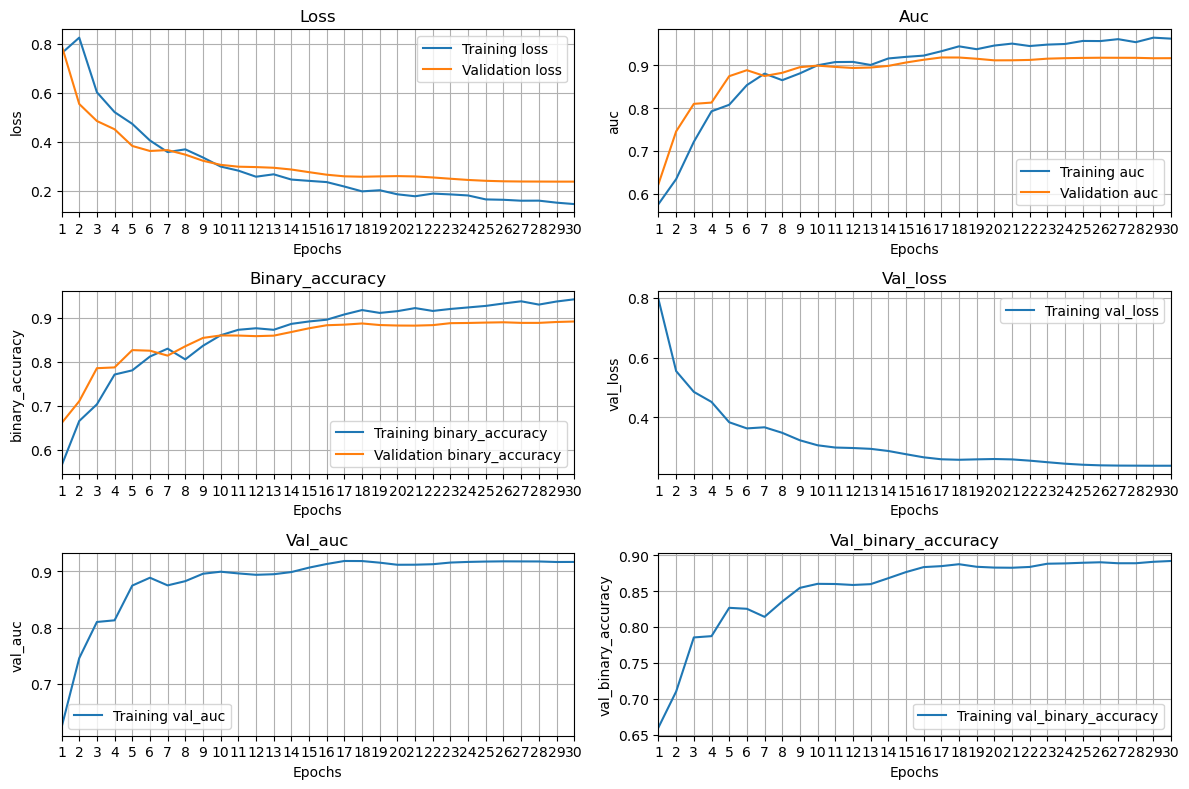

In [15]:
plot_metrics(history)

 ### Next comes the most fun part, we make a prediction!!!!! 
 #### Below I have few lines of code to pick a random image from our Test Dataset, plot it, and compare the predicted answers to  the actual answers. After the model has compiled, this cell can be run repeatedly and indepedently to make new predictions!

16/16 [==============================] - 3s 123ms/step
Actual metrics: ['On land', 'Holding an Item', 'Safe from Mob Spawns', 'Low Health']
Predicted metrics: ['On land', 'Holding an Item', 'Safe from Mob Spawns', 'Low Health']


2024-12-16 09:28:12.998337: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


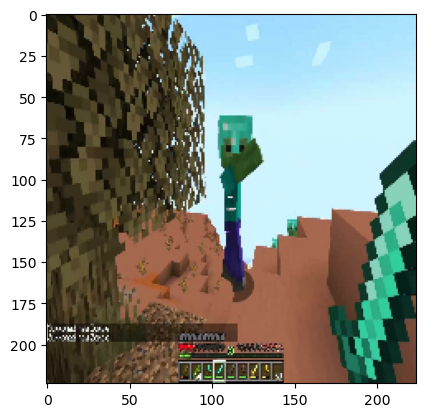

In [16]:
for features, labels in test_dataset.take(1):
    rN = random.randint(0, len(features) - 1)
    logits = model.predict(features)
    probabilities = tf.nn.sigmoid(logits).numpy()
    
    print(f'Actual metrics: {decider(labels[rN].numpy())}')
    print(f'Predicted metrics: {decider(probabilities[rN])}')
    plt.imshow(features[rN].numpy())

## And that's it! This model isn't my most robust, but it's an NDA-safe example of my DL experience!